# Experiment Setup 4: Learning Rates
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
This experiment aims to investigate the effects a larger and smaller learning rate has on the base LSTM model.
 
#### Import Modules

In [53]:
import pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from functools import lru_cache
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [54]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_WORD = 200

BATCH_SIZE = 128
EPOCHS = 5

#### Functions

In [55]:
def pickle_dataset(filename, dataset):
    file = open("{0}.pickle".format(filename),"wb")
    pickle.dump(dataset, file)
    file.close()

In [56]:
def round_pred(predictions):
    y_pred = [prediction.round() for prediction in predictions]
    
    return y_pred

In [57]:
def gen_confusion_matrix(y_true,y_pred):
    confusion_matrices={}

    for label_col in range(len(LABEL_FIELDS)):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]
        confusion_matrices[LABEL_FIELDS[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
    return confusion_matrices

In [58]:
def plot_precision_recall_curve(y_test,y_pred):
    precision = dict()
    recall = dict()

    for i in range(len(LABEL_FIELDS)):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        plt.plot(recall[i], precision[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend(loc="best")
    plt.title("precision vs. recall curve")
    plt.show()

In [59]:
def plot_roc_curve(y_test, y_pred):
    # roc curve
    fpr = dict()
    tpr = dict()

    for i in range(len(LABEL_FIELDS)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],
                                      y_pred[:, i])
        plt.plot(fpr[i], tpr[i], lw=2, label='{}'.format(LABEL_FIELDS[i]))

    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    plt.legend(loc="best")
    plt.title("ROC curve")
    plt.show()

In [60]:
def build_model(learning_rate=0.001):
    model = Sequential()
    model.add(Embedding(len(corpus) + 1, 100, input_length=150))
    model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    optimiser = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

    return model


#### Read in preprocessed test and train datasets

In [61]:
train = pickle.load(open("balanced_train.pickle", "rb"))
test = pickle.load(open("balanced_test.pickle", "rb"))

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

y_train = pickle.load(open("balanced_train_labels.pickle", "rb"))

x_sequences_test = tokenizer.texts_to_sequences(test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

y_test = pickle.load(open("balanced_test_labels.pickle", "rb"))

In [62]:
print(x_padded_train.shape)
print(y_train.shape)
print(x_padded_test.shape)
print(y_test.shape)

(78598, 150)
(78598, 6)
(10875, 150)
(10875, 6)


#### Smaller learning rate (=0.0005)

In [63]:
modelSmallLR = build_model(learning_rate=0.0005)
history = modelSmallLR.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
553/553 [==============================] - 231s 418ms/step - loss: 0.2753 - accuracy: 0.3868 - val_loss: 0.0921 - val_accuracy: 0.9945
Epoch 2/5
553/553 [==============================] - 234s 422ms/step - loss: 0.1021 - accuracy: 0.6916 - val_loss: 0.0493 - val_accuracy: 0.9952
Epoch 3/5
553/553 [==============================] - 230s 416ms/step - loss: 0.0774 - accuracy: 0.9097 - val_loss: 0.0480 - val_accuracy: 0.9952
Epoch 4/5
553/553 [==============================] - 232s 419ms/step - loss: 0.0711 - accuracy: 0.9549 - val_loss: 0.0475 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 229s 415ms/step - loss: 0.0668 - accuracy: 0.9673 - val_loss: 0.0483 - val_accuracy: 0.9952


In [64]:
modelSmallLR.save("./learning_rate_experiment/small_lr_model")

INFO:tensorflow:Assets written to: ./learning_rate_experiment/small_lr_model\assets


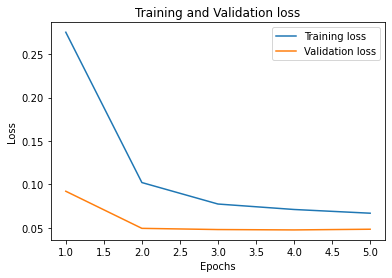

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [66]:
pickle_dataset("lossLargeLR", loss)
pickle_dataset("valLossLargeLR", val_loss)

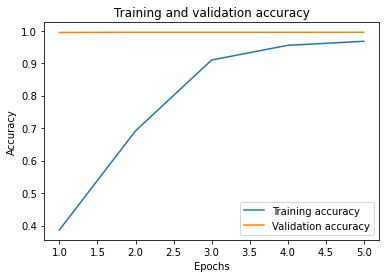

In [67]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [68]:
pickle_dataset("accLargeLR", accuracy)
pickle_dataset("valAccLargeLR", val_accuracy)

In [69]:
pred = modelSmallLR.predict(x_padded_test)

In [70]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


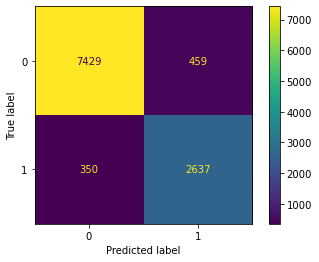

In [71]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


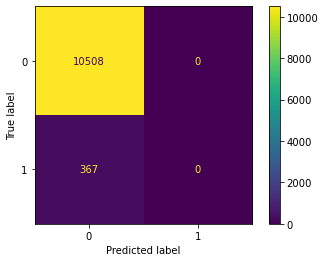

In [72]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


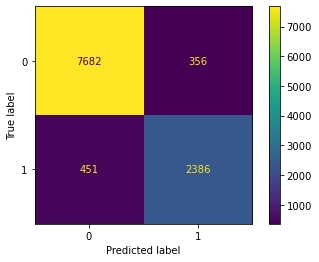

In [73]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


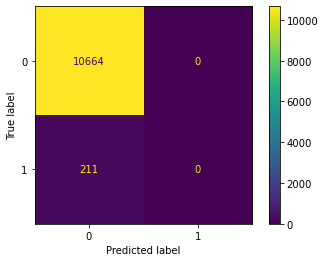

In [74]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


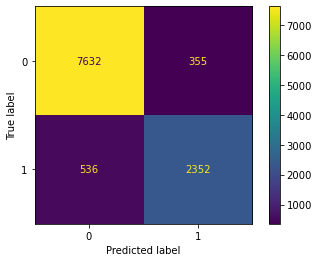

In [75]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


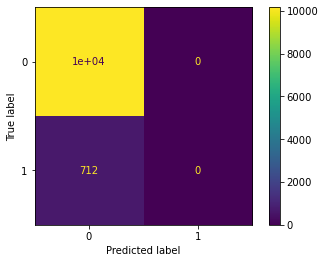

In [76]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

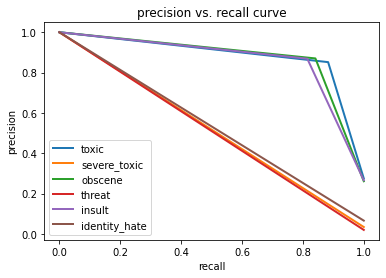

In [77]:
plot_precision_recall_curve(y_test,y_pred)

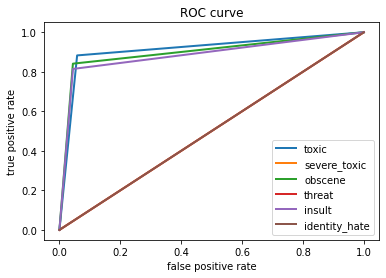

In [78]:
plot_roc_curve(y_test,y_pred)

In [79]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      2987
           1       0.00      0.00      0.00       367
           2       0.87      0.84      0.86      2837
           3       0.00      0.00      0.00       211
           4       0.87      0.81      0.84      2888
           5       0.00      0.00      0.00       712

   micro avg       0.86      0.74      0.80     10002
   macro avg       0.43      0.42      0.43     10002
weighted avg       0.75      0.74      0.74     10002
 samples avg       0.24      0.21      0.22     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Larger learning rate (=0.05)

In [80]:
modelLargeLR = build_model(learning_rate=0.05)
history = modelLargeLR.fit(x_padded_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
553/553 [==============================] - 230s 415ms/step - loss: 0.1428 - accuracy: 0.8137 - val_loss: 0.0625 - val_accuracy: 0.9949
Epoch 2/5
553/553 [==============================] - 242s 437ms/step - loss: 0.1246 - accuracy: 0.8344 - val_loss: 0.0641 - val_accuracy: 0.9679
Epoch 3/5
553/553 [==============================] - 248s 449ms/step - loss: 0.1226 - accuracy: 0.8090 - val_loss: 0.0745 - val_accuracy: 0.0497
Epoch 4/5
553/553 [==============================] - 247s 447ms/step - loss: 0.1216 - accuracy: 0.8135 - val_loss: 0.0600 - val_accuracy: 0.9952
Epoch 5/5
553/553 [==============================] - 240s 433ms/step - loss: 0.1182 - accuracy: 0.8108 - val_loss: 0.0610 - val_accuracy: 0.9648


In [81]:
modelLargeLR.save("./learning_rate_experiment/large_lr_model")

INFO:tensorflow:Assets written to: ./learning_rate_experiment/large_lr_model\assets


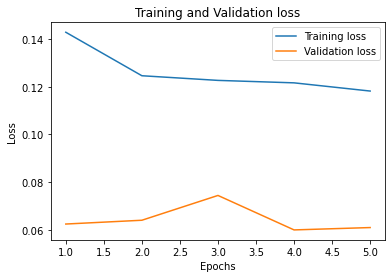

In [82]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [83]:
pickle_dataset("lossLargeLR", loss)
pickle_dataset("valLossLargeLR", val_loss)

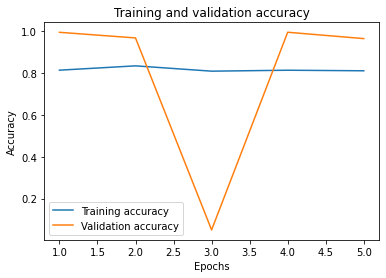

In [84]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [85]:
pickle_dataset("accLargeLR", accuracy)
pickle_dataset("valAccLargeLR", val_accuracy)

In [86]:
pred = modelLargeLR.predict(x_padded_test)

In [87]:
y_pred = round_pred(pred)
y_pred = np.asarray(y_pred)
confusion_matrices = gen_confusion_matrix(y_test,y_pred)

Confusion Matrix: toxic


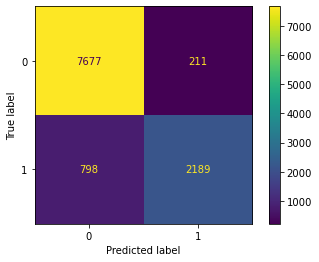

In [88]:
print("Confusion Matrix: " + LABEL_FIELDS[0])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[0]])
disp.plot()

Confusion Matrix: severe_toxic


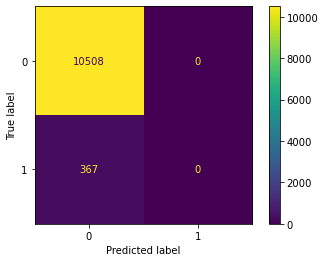

In [89]:
print("Confusion Matrix: " + LABEL_FIELDS[1])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[1]])
disp.plot()

Confusion Matrix: obscene


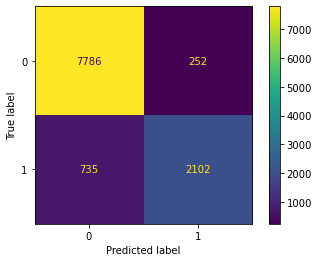

In [90]:
print("Confusion Matrix: " + LABEL_FIELDS[2])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[2]])
disp.plot()

Confusion Matrix: threat


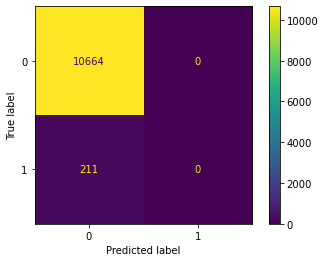

In [91]:
print("Confusion Matrix: " + LABEL_FIELDS[3])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[3]])
disp.plot()

Confusion Matrix: insult


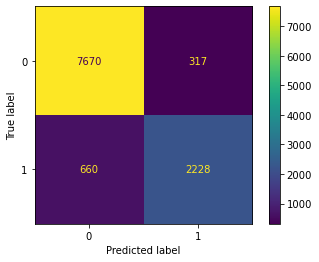

In [92]:
print("Confusion Matrix: " + LABEL_FIELDS[4])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[4]])
disp.plot()

Confusion Matrix: identity_hate


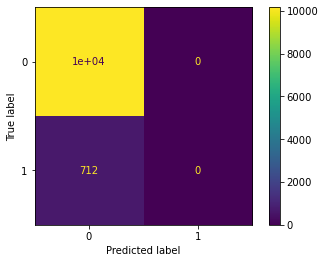

In [93]:
print("Confusion Matrix: " + LABEL_FIELDS[5])
disp = ConfusionMatrixDisplay(confusion_matrices[LABEL_FIELDS[5]])
disp.plot()

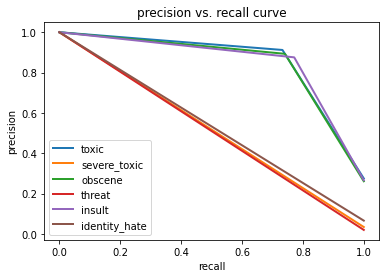

In [94]:
plot_precision_recall_curve(y_test,y_pred)

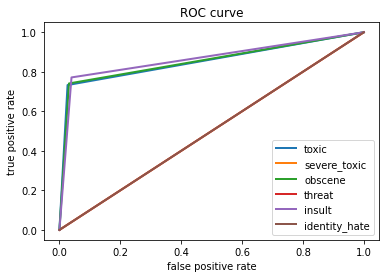

In [95]:
plot_roc_curve(y_test,y_pred)

In [96]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test, y_pred)
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      2987
           1       0.00      0.00      0.00       367
           2       0.89      0.74      0.81      2837
           3       0.00      0.00      0.00       211
           4       0.88      0.77      0.82      2888
           5       0.00      0.00      0.00       712

   micro avg       0.89      0.65      0.75     10002
   macro avg       0.45      0.37      0.41     10002
weighted avg       0.78      0.65      0.71     10002
 samples avg       0.21      0.18      0.19     10002



C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vinal\anaconda3\envs\grp7_env\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Discussion
From this setup, it is evident that the learning rate can affect the model's ability to learn, as having a larger learning rate has resulted in overfitting. This conclusion can be drawn from the training history as it reaches a point where the accuracy decreases with more epochs. A larger learning results in larger jumps in the objective space, making it harder for the model to find the global optimum. From the classification report above, you can see that the larger learning has slightly increased the precision of predicting certain labels, but has decreased the recall by a greater amount, leading to an overall decrease in f1 score this model.

The results with a smaller learning rate slightly improves the f1 scores for the model, however, the nature of a smaller learning rate than the base model means that more epochs are needed for the model to generalise the dataset. To summarise, the best setup from this experiment would be the base learning rate, as it is able to get relatively the same results as using a smaller learning rate with less epochs. Having a larger learning rate with less epochs to reduce overfitting is not suitable, as there is a risk the model won't be able to generalise the dataset. Changing the learning rate also did not lead to the model generalising the "severe_toxic", "threat" and "identity_hate" labels. 